In [1]:


# Pre-processing
from skimage.feature import local_binary_pattern
from skimage import io
from PIL import Image
from skimage.color import label2rgb

# model
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image


## Pre-processing images

In [2]:



def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def flat_local_binary_pattern(image):
    image = image * 255
    image = image.astype(np.uint8) 
    image = Image.fromarray(image)

    image = image.convert("L")


    METHOD = 'uniform'
    # settings for LBP
    radius = 3
    n_points = 8 * radius

    w = width = radius - 1

    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    # io.imshow(lbp)
    lbp_image = overlay_labels(np.array(image), lbp, flat_labels)
    
    return np.array(lbp_image)

In [3]:
# I think we have enought images, if not we do image augmentation
train_datagen = image.ImageDataGenerator(
    preprocessing_function=flat_local_binary_pattern,
    rescale = 1./255,
    # shear_range = 0.2
    # zoom_range = 0.2
    # horizontal_flip = True,

)
test_dataset = image.ImageDataGenerator(
    preprocessing_function=flat_local_binary_pattern,
    rescale=1/255,
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    'data\\train\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

test_generator = test_dataset.flow_from_directory(
    'data\\test\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

Found 19486 images belonging to 2 classes.
Found 9599 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

## Model 

In [6]:
# Using as a base model
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation='ReLU', input_shape=(224,224, 3))) # Need to check the mean size of the pictures for better performance

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='ReLU'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [7]:
steps = train_generator.samples / train_generator.batch_size
steps = round(steps)

history = model.fit(
    train_generator,
    steps_per_epoch = 10,#steps,
    epochs = 10,
    validation_data = train_generator,
    validation_steps = 2
)

Epoch 1/10
10/10 [==============================] - 119s 11s/step - loss: 0.7528 - accuracy: 0.6375 - val_loss: 0.6921 - val_accuracy: 0.6250
Epoch 2/10
10/10 [==============================] - 120s 12s/step - loss: 0.6901 - accuracy: 0.6969 - val_loss: 0.6874 - val_accuracy: 0.7188
Epoch 3/10
10/10 [==============================] - 145s 15s/step - loss: 0.6857 - accuracy: 0.6969 - val_loss: 0.6833 - val_accuracy: 0.6875
Epoch 4/10
10/10 [==============================] - 109s 10s/step - loss: 0.6819 - accuracy: 0.6719 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 5/10
10/10 [==============================] - 61s 6s/step - loss: 0.6816 - accuracy: 0.6219 - val_loss: 0.6809 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 61s 6s/step - loss: 0.6795 - accuracy: 0.6438 - val_loss: 0.6745 - val_accuracy: 0.6562
Epoch 7/10
10/10 [==============================] - 60s 6s/step - loss: 0.6778 - accuracy: 0.6281 - val_loss: 0.6695 - val_accuracy: 0.6719
Epoch 8/10
1

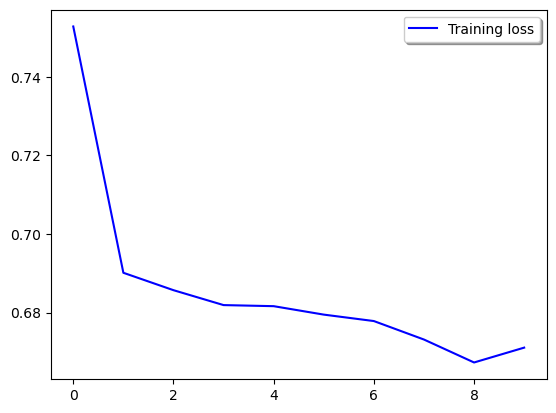

In [8]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)

In [9]:
model.evaluate(test_generator)

300/300 [==============================] - 1083s 4s/step - loss: 0.6579 - accuracy: 0.6828


[0.6579161286354065, 0.6827794313430786]